<a href="https://colab.research.google.com/github/Mshuning/DNSC6290/blob/main/Assignment%203/assignment_3_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## License 

Copyright 2021 Patrick Hall (jphall@gwu.edu), Shuning Ma (shuningma@gwu.edu)

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

*DISCLAIMER*: This notebook is not legal or compliance advice.

# Assignment 3 XGBoost

#### Imports and inits

In [ ]:
!pip install -r requirements.txt

You should consider upgrading via the 'D:\AppData\Local\Anaconda3\python.exe -m pip install --upgrade pip' command.


In [ ]:
import itertools                                              # for cartesian product of parameters
import matplotlib.pyplot as plt                               # basic plotting
import numpy as np                                            # for basic array manipulation                            
import pandas as pd                                           # for dataframe manipulation
import random                                                 # to sample from lists
import time                                                   # for timers
import xgboost as xgb                                         # base xgboost package for python
from sklearn.metrics import accuracy_score, f1_score          # for selecting model cutoffs

# set numpy random seed for better reproducibility
SEED = 12345 

# set number of threads
NTHREAD = 4

### Define utility functions

#### Utility function to calculate confusion matrices by demographic group

In [ ]:
def get_confusion_matrix(frame, y, yhat, by=None, level=None, cutoff=0.5, verbose=True):

    """ Creates confusion matrix from pandas dataframe of y and yhat values, can be sliced 
        by a variable and level.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Name of actual value column.
        :param yhat: Name of predicted value column.
        :param by: By variable to slice frame before creating confusion matrix, default None.
        :param level: Value of by variable to slice frame before creating confusion matrix, default None.
        :param cutoff: Cutoff threshold for confusion matrix, default 0.5. 
        :param verbose: Whether to print confusion matrix titles, default True. 
        :return: Confusion matrix as pandas dataframe. 
        
    """
    
    # determine levels of target (y) variable
    # sort for consistency
    level_list = list(frame[y].unique())
    level_list.sort(reverse=True) 

    # init confusion matrix
    cm_frame = pd.DataFrame(columns=['actual: ' +  str(i) for i in level_list], 
                            index=['predicted: ' + str(i) for i in level_list])
    
    # don't destroy original data
    frame_ = frame.copy(deep=True)
    
    # convert numeric predictions to binary decisions using cutoff
    dname = 'd_' + str(y)
    frame_[dname] = np.where(frame_[yhat] > cutoff , 1, 0)
    
    # slice frame
    if (by is not None) & (level is not None):
        frame_ = frame_[frame[by] == level]
    
    # calculate size of each confusion matrix value
    for i, lev_i in enumerate(level_list):
        for j, lev_j in enumerate(level_list):
            cm_frame.iat[j, i] = frame_[(frame_[y] == lev_i) & (frame_[dname] == lev_j)].shape[0]
            # i, j vs. j, i nasty little bug ... updated 8/30/19
    
    # output results
    if verbose:
        if by is None:
            print('Confusion matrix:')
        else:
            print('Confusion matrix by ' + by + '=' + str(level))
    
    return cm_frame

#### Utility function to calculate AIR

In [ ]:
def air(cm_dict, reference_key, protected_key, verbose=True):

    """ Calculates the adverse impact ratio as a quotient between protected and 
        reference group acceptance rates: protected_prop/reference_prop. 
        Optionally prints intermediate values. ASSUMES 0 IS "POSITIVE" OUTCOME!

        :param cm_dict: Dictionary of demographic group confusion matrices. 
        :param reference_key: Name of reference group in cm_dict as a string.
        :param protected_key: Name of protected group in cm_dict as a string.
        :param verbose: Whether to print intermediate acceptance rates, default True. 
        :return: AIR.
        
    """

    eps = 1e-20 # numeric stability and divide by 0 protection
    
    # reference group summary
    reference_accepted = float(cm_dict[reference_key].iat[1,0] + cm_dict[reference_key].iat[1,1]) # predicted 0's
    reference_total = float(cm_dict[reference_key].sum().sum())
    reference_prop = reference_accepted/reference_total
    if verbose:
        print(reference_key.title() + ' proportion accepted: %.3f' % reference_prop)
    
    # protected group summary
    protected_accepted = float(cm_dict[protected_key].iat[1,0] + cm_dict[protected_key].iat[1,1]) # predicted 0's
    protected_total = float(cm_dict[protected_key].sum().sum())
    protected_prop = protected_accepted/protected_total
    if verbose:
        print(protected_key.title() + ' proportion accepted: %.3f' % protected_prop)

    # return adverse impact ratio
    return ((protected_prop + eps)/(reference_prop + eps))


#### Utility function to select probability cutoff by F1

In [ ]:
def get_max_f1_frame(frame, y, yhat, res=0.01, air_reference=None, air_protected=None): 
    
    """ Utility function for finding max. F1. 
        Coupled to get_confusion_matrix() and air(). 
        Assumes 1 is the marker for class membership.
    
        :param frame: Pandas dataframe of actual (y) and predicted (yhat) values.
        :param y: Known y values.
        :param yhat: Model scores.
        :param res: Resolution over which to search for max. F1, default 0.01.
        :param air_reference: Reference group for AIR calculation, optional.
        :param air_protected: Protected group for AIR calculation, optional.
        :return: Pandas DataFrame of cutoffs to select from.
    
    """
    
    do_air = all(v is not None for v in [air_reference, air_protected])
    
    # init frame to store f1 at different cutoffs
    if do_air:
        columns = ['cut', 'f1', 'acc', 'air']
    else:
        columns = ['cut', 'f1', 'acc']
    f1_frame = pd.DataFrame(columns=['cut', 'f1', 'acc'])
    
    # copy known y and score values into a temporary frame
    temp_df = frame[[y, yhat]].copy(deep=True)
    
    # find f1 at different cutoffs and store in acc_frame
    for cut in np.arange(0, 1 + res, res):
        temp_df['decision'] = np.where(temp_df.iloc[:, 1] > cut, 1, 0)
        f1 = f1_score(temp_df.iloc[:, 0], temp_df['decision'])
        acc = accuracy_score(temp_df.iloc[:, 0], temp_df['decision'])
        row_dict = {'cut': cut, 'f1': f1, 'acc': acc}
        if do_air:
            # conditionally calculate AIR  
            cm_ref = get_confusion_matrix(frame, y, yhat, by=air_reference, level=1, cutoff=cut, verbose=False)
            cm_pro = get_confusion_matrix(frame, y, yhat, by=air_protected, level=1, cutoff=cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            
        f1_frame = f1_frame.append(row_dict, ignore_index=True)
            
    del temp_df
        
    return f1_frame

#### Define utility function for random grid search

In [ ]:
def xgb_grid(train, valid, x_names, y_name, mono_constraints=None, gs_params=None, n_models=None,
             ntree=None, early_stopping_rounds=None, verbose=False, seed=None, air_reference=None, air_protected=None, air_cut=None):
    
    """ Performs a random grid search over n_models and gs_params.

    :param dtrain: Training data in LightSVM format.
    :param dvalid: Validation data in LightSVM format.
    :param x_names: Names of input features.
    :param y_name: Name of target feature.
    :param mono_constraints: User-supplied monotonicity constraints.
    :param gs_params: Dictionary of lists of potential XGBoost parameters over which to search.
    :param n_models: Number of random models to evaluate.
    :param ntree: Number of trees in XGBoost model.
    :param early_stopping_rounds: XGBoost early stopping rounds.
    :param verbose: Whether to display training iterations, default False.
    :param seed: Random seed for better interpretability.
    :param air_reference: Reference group for AIR calculation, optional.
    :param air_protected: Protected group for AIR calculation, optional.  
    :param air_cut: Cutoff for AIR calculation, optional.
    :return: Best candidate model from random grid search.

    """

    # init returned frame
    do_air = all(v is not None for v in [air_reference, air_protected])
    if do_air: 
        columns = list(gs_params.keys()) + ['features', 'auc', 'air']
    else:
        columns = list(gs_params.keys()) + ['auc']
    xgb_grid_frame = pd.DataFrame(columns=columns)
    
    # cartesian product of gs_params
    keys, values = zip(*gs_params.items())
    experiments = [dict(zip(keys, v)) for v in itertools.product(*values)]

    # preserve exact reproducibility for this function
    np.random.seed(SEED) 
    
    # select randomly from cartesian product space
    selected_experiments = np.random.choice(len(experiments), n_models)

    # set global params for objective,  etc.
    params = {'booster': 'gbtree',
              'eval_metric': 'auc',
              'nthread': NTHREAD,
              'objective': 'binary:logistic',
              'seed': SEED}

    # init grid search loop
    best_candidate = None
    best_score = 0

    # grid search loop
    for i, exp in enumerate(selected_experiments):
        
        params.update(experiments[exp])  # override global params with current grid run params
        
        print('Grid search run %d/%d:' % (int(i + 1), int(n_models)))
        print('Training with parameters:', params)

        # conditionally select random features 
        features = x_names
        if do_air:
            n_features = random.randrange(len(x_names)) + 1
            features = random.sample(x_names, n_features)
            
        # Convert data to SVMLight format
        dtrain = xgb.DMatrix(train[features], train[y_name])
        dvalid = xgb.DMatrix(valid[features], valid[y_name])  
        
        # train on current params
        watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
        
        if mono_constraints is not None:
            temp = []
            for j in features:
                temp.append(x_names.index(j))
            temp.sort()

            params['monotone_constraints'] = tuple([list(mono_constraints)[k] for k in temp])
        
        candidate = xgb.train(params,
                              dtrain,
                              ntree,
                              early_stopping_rounds=early_stopping_rounds,
                              evals=watchlist,
                              verbose_eval=verbose)    
        
        # compose values to add to xgb_grid_frame
        row_dict = params.copy()
        row_dict['auc'] = candidate.best_score
        if do_air:
            # collect random feature set
            row_dict['features'] = features
            # conditionally calculate AIR  
            valid_phat = valid.copy(deep=True)
            valid_phat['phat'] = candidate.predict(dvalid)
            cm_ref = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_reference, level=1, cutoff=air_cut, verbose=False)
            cm_pro = get_confusion_matrix(valid_phat, y_name, 'phat', by=air_protected, level=1, cutoff=air_cut, verbose=False)
            air_ = air({air_reference: cm_ref, air_protected: cm_pro}, air_reference, air_protected, verbose=False)
            row_dict['air'] = air_
            del valid_phat

        # append run to xgb_grid_frame
        xgb_grid_frame = xgb_grid_frame.append(row_dict, ignore_index=True)
        
        # determine if current model is better than previous best
        if candidate.best_score > best_score:
            best_candidate = candidate
            best_score = candidate.best_score
            print('Grid search new best score discovered at iteration %d/%d: %.4f.' %
                             (int(i + 1), int(n_models), candidate.best_score))

        print('---------- ----------')
        
        del row_dict
            
    return best_candidate, xgb_grid_frame

#### Start global timer

In [ ]:
tic = time.time()

#### Import data

In [ ]:
data = pd.read_csv('../data/hmda_train_preprocessed.csv')
test = pd.read_csv('../data/hmda_test_preprocessed.csv')

#### Assign basic modeling roles

In [ ]:
y_name = 'high_priced'
x_names = ['term_360', 'conforming', 'debt_to_income_ratio_missing', 'loan_amount_std', 'loan_to_value_ratio_std', 'no_intro_rate_period_std',
           'intro_rate_period_std', 'property_value_std', 'income_std', 'debt_to_income_ratio_std']

## Fit interpretable models

#### Split data into train and validation partitions 

In [ ]:
np.random.seed(SEED) # preserve exact reproducibility for this cell

split_ratio = 0.7 # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
valid = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Validation data rows = %d, columns = %d' % (valid.shape[0], valid.shape[1]))

# benchmark - Train data rows = 112253, columns = 23
# benchmark - Validation data rows = 48085, columns = 23

Train data rows = 112253, columns = 23
Validation data rows = 48085, columns = 23


#### Fit monotonic XGBoost with random grid search

In [ ]:
# dictionary of hyperparameter value lists for grid search
gs_params = {'colsample_bytree': [0.3, 0.5, 0.7, 0.9],
             'colsample_bylevel': [0.3, 0.5, 0.7, 0.9],
             'eta': [0.005, 0.05, 0.5],
             'max_depth': [3, 5, 7],
             'reg_alpha': [0.0005, 0.005, 0.05],
             'reg_lambda': [0.0005, 0.005, 0.05],
             'subsample': [0.3, 0.5, 0.7, 0.9],
             'min_child_weight': [1, 5, 10], 
             'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4]}

# define monotonicity constraints
mono_constraints = tuple([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

# start local timer
mxgb_tic = time.time()

# Monotonic XGBoost grid search
best_mxgb, mxgb_grid_frame = xgb_grid(train, valid, x_names, y_name, gs_params=gs_params, n_models=40, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=mono_constraints, seed=SEED)

# end local timer
mxgb_toc = time.time() - mxgb_tic
print('Monotonic GBM training completed in %.2f s.' % (mxgb_toc))

Grid search run 1/40:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/40: 0.7909.
---------- ----------
Grid search run 2/40:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 3/40:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

---------- ----------
Grid search run 21/40:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
---------- ----------
Grid search run 22/40:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 1, 1, -1, -1, -1, 1)}
Grid search new best score discovered at iteration 22/40: 0.7916.
---------- ----------
Grid search run 23/40:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc'

---------- ----------
Monotonic GBM training completed in 766.04 s.


#### Find best monotonic constraints

In [ ]:
best_gs_params = {'colsample_bytree': [0.9],
             'colsample_bylevel': [0.9],
             'eta': [0.5],
             'max_depth': [7],
             'reg_alpha': [0.0005],
             'reg_lambda': [0.005],
             'subsample': [0.7],
             'min_child_weight': [10], 
             'gamma': [0.4]}

best_mono_constraints = list([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])
temp_mono_constraints = list([int(i) for i in np.sign(train[x_names + [y_name]].corr()[y_name].values[:-1])])

for i in range(len(mono_constraints)):

    for j in range(-1, 2):
        temp_mono_constraints[i] = j
        candidate = xgb_grid(train, valid, x_names, y_name, gs_params=best_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                         mono_constraints=tuple(temp_mono_constraints), seed=SEED)

        if candidate.best_score > best_mxgb.best_score:
            best_mono_constraints[i] = j
            best_mxgb = candidate
            best_score = candidate.best_score

            print('Monotone_constraints search new best score discovered with constraints {}: {}'.format(best_mono_constraints, best_mxgb.best_score))
            print()

        else:
            temp_mono_constraints[i] = best_mono_constraints[i]

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4}
Grid search new best score discovered at iteration 1/1: 0.7904.
---------- ----------
Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4}
Grid search new best score discovered at iteration 1/1: 0.7914.
---------- ----------
Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

Grid search new best score discovered at iteration 1/1: 0.8185.
---------- ----------
Monotone_constraints search new best score discovered with constraints [1, 1, 1, -1, 0, -1, 0, -1, -1, 1]: 0.818487

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4}
Grid search new best score discovered at iteration 1/1: 0.8111.
---------- ----------
Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4}
Grid search new best score discovered at iteration 1/

In [ ]:
best_gs_params = {'colsample_bytree': [0.9],
             'colsample_bylevel': [0.9],
             'eta': [0.5],
             'max_depth': [7],
             'reg_alpha': [0.0005],
             'reg_lambda': [0.005],
             'subsample': [0.7],
             'min_child_weight': [10], 
             'gamma': [0.4]}

best_mono_constraints = (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)

best_mxgb = xgb_grid(train, valid, x_names, y_name, gs_params=best_gs_params, n_models=1, ntree=1000, early_stopping_rounds=100, 
                     mono_constraints=best_mono_constraints, seed=SEED)

Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4}
Grid search new best score discovered at iteration 1/1: 0.8251.
---------- ----------


#### Basic AUC assessment

In [ ]:
print('Validation AUC: %.4f.' % best_mxgb.best_score)

Validation AUC: 0.8251.


#### Score validation data with model

In [ ]:
dvalid = xgb.DMatrix(valid[x_names], valid[y_name])
best_mxgb_phat = pd.DataFrame(best_mxgb.predict(dvalid, iteration_range=(0, best_mxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat = pd.concat([valid.reset_index(drop=True), best_mxgb_phat], axis=1)
best_mxgb_phat.head()

,row_id,black,asian,white,amind,hipac,hispanic,non_hispanic,male,female,...,debt_to_income_ratio_missing,loan_amount_std,loan_to_value_ratio_std,no_intro_rate_period_std,intro_rate_period_std,property_value_std,income_std,debt_to_income_ratio_std,high_priced,phat
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,...,0,-0.514393,0.333922,0.244394,-0.215304,-0.535932,-0.040307,0.854601,0,0.183308
1,6,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0,-0.426448,0.355249,0.244394,-0.215304,-0.474263,-0.020904,1.037419,0,0.321787
2,8,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,0.277109,0.142995,0.244394,-0.215304,0.111598,-0.019865,0.031916,0,0.018835
3,10,0.0,0.0,1.0,0.0,0.0,0.0,1.0,NaN,NaN,...,0,-0.382476,-0.240432,0.244394,-0.215304,-0.320089,-0.028181,0.946010,0,0.010125
4,11,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN,...,0,0.101220,-0.266529,0.244394,-0.215304,0.111598,0.016515,-1.156406,0,0.004877


#### Find optimal cutoff based on F1

In [ ]:
f1_frame = get_max_f1_frame(best_mxgb_phat, y_name, 'phat')

print(f1_frame)
print()

max_f1 = f1_frame['f1'].max()
best_cut = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'cut'] #idxmax() returns the index of the maximum value
acc = f1_frame.loc[int(f1_frame['f1'].idxmax()), 'acc']

print('Best EBM F1: %.4f achieved at cutoff: %.2f with accuracy: %.4f.' % (max_f1, best_cut, acc))

      cut        f1       acc
0    0.00  0.173860  0.095206
1    0.01  0.229942  0.369845
2    0.02  0.262763  0.479526
3    0.03  0.283057  0.536675
4    0.04  0.297262  0.572965
..    ...       ...       ...
96   0.96  0.000000  0.904794
97   0.97  0.000000  0.904794
98   0.98  0.000000  0.904794
99   0.99  0.000000  0.904794
100  1.00  0.000000  0.904794

[101 rows x 3 columns]

Best EBM F1: 0.3680 achieved at cutoff: 0.17 with accuracy: 0.7816.


#### Find confusion matrices for demographic groups

In [ ]:
demographic_group_names = ['black', 'asian', 'white', 'male', 'female']
cm_dict = {}

for name in demographic_group_names:
    cm_dict[name] = get_confusion_matrix(best_mxgb_phat, y_name, 'phat', by=name, level=1, cutoff=best_cut)
    print(cm_dict[name])
    print()

Confusion matrix by black=1
             actual: 1 actual: 0
predicted: 1       491       979
predicted: 0       173      1549

Confusion matrix by asian=1
             actual: 1 actual: 0
predicted: 1        96       201
predicted: 0        52      2901

Confusion matrix by white=1
             actual: 1 actual: 0
predicted: 1      2081      6630
predicted: 0      1084     24730

Confusion matrix by male=1
             actual: 1 actual: 0
predicted: 1      1122      3421
predicted: 0       542     10747

Confusion matrix by female=1
             actual: 1 actual: 0
predicted: 1       872      2355
predicted: 0       368      6437



#### Find AIR

In [ ]:
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(cm_dict, 'white', 'asian'))

White proportion accepted: 0.748
Asian proportion accepted: 0.909
Adverse impact ratio for Asian people vs. White people: 1.215


In [ ]:
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(cm_dict, 'white', 'black'))

White proportion accepted: 0.748
Black proportion accepted: 0.539
Adverse impact ratio for Black people vs. White people: 0.722


In [ ]:
print('Adverse impact ratio for Females vs. Males: %.3f' % air(cm_dict, 'male', 'female'))

Male proportion accepted: 0.713
Female proportion accepted: 0.678
Adverse impact ratio for Females vs. Males: 0.951


### Attempt remediation of discovered discrimination

#### Simplest remediation: Find cutoff with better Black vs. White AIR

In [ ]:
f1_frame = get_max_f1_frame(best_mxgb_phat, y_name, 'phat', air_reference='white', air_protected='black')
# print highest quality cutoffs above four fifths rule cutoff
f1_frame[f1_frame['air'] > 0.8].sort_values(by='f1', ascending=False).head()

,cut,f1,acc,air
21,0.21,0.360071,0.826952,0.809933
22,0.22,0.359573,0.836727,0.826980
23,0.23,0.352605,0.844442,0.841856
24,0.24,0.341737,0.853385,0.855633
25,0.25,0.327459,0.861100,0.877858


Cutoffs in the 0.21-0.25 range provide increased accuracy and less bias towards Black people. 

#### Check that other groups are not adversely impacted by change 

In [ ]:
# calculate new confusion matrics for each group
rem_cm_dict = {}
for name in demographic_group_names:
    rem_cm_dict[name] = get_confusion_matrix(best_mxgb_phat, y_name, 'phat', by=name, level=1, cutoff=0.21, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.141
Adverse impact ratio for Black people vs. White people: 0.810
Adverse impact ratio for Females vs. Males: 0.964


The new cutoff does not adversely affect other protected groups. 

#### More sophisticated remdiation: Model selection via quality and fairness

In [ ]:
# start local timer
mxgb2_tic = time.time()

# define monotonicity constraints
best_mono_constraints = (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)

# new grid search that also considers AIR and fairness
best_mxgb2, mxgb_grid_frame = xgb_grid(train, best_mxgb_phat, x_names, y_name, gs_params=gs_params, n_models=500, ntree=1000, 
                                     early_stopping_rounds=100, mono_constraints=best_mono_constraints, seed=SEED, air_reference='white', air_protected='black', 
                                     air_cut=0.17)

# end local timer
mxgb2_toc = time.time() - mxgb2_tic
print('EBM training completed in %.2f s.' % (ebm2_toc))

Grid search run 1/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0}
Grid search new best score discovered at iteration 1/500: 0.6688.
---------- ----------
Grid search run 2/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, 0, 0)}
Grid search new best score discovered at iteration 2/500: 0.7951.
---------- ----------
Grid search run 3/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary

---------- ----------
Grid search run 22/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (1, -1, 0, -1, 0)}
---------- ----------
Grid search run 23/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 1)}
---------- ----------
Grid search run 24/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree':

---------- ----------
Grid search run 43/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, -1, 0, -1, 1, 0, 1)}
---------- ----------
Grid search run 44/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1)}
---------- ----------
Grid search run 45/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'cols

---------- ----------
Grid search run 64/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 65/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (-1, -1)}
---------- ----------
Grid search run 66/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 

---------- ----------
Grid search run 85/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 0, 0)}
---------- ----------
Grid search run 86/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 0, -1, 0, 0)}
---------- ----------
Grid search run 87/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsampl

---------- ----------
Grid search run 106/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 0, 1)}
---------- ----------
Grid search run 107/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.1, 'monotone_constraints': (1, 1, -1, -1, 0, 1)}
---------- ----------
Grid search run 108/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, '

---------- ----------
Grid search run 127/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.0, 'monotone_constraints': (0, -1, 1)}
---------- ----------
Grid search run 128/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 129/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 

---------- ----------
Grid search run 148/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 0, 1)}
---------- ----------
Grid search run 149/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 0, 1)}
---------- ----------
Grid search run 150/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsam

---------- ----------
Grid search run 169/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1, 0, 1, 1)}
---------- ----------
Grid search run 170/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (-1, 0, -1, 0, 1)}
---------- ----------
Grid search run 171/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'cols

---------- ----------
Grid search run 190/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.0, 'monotone_constraints': (1, 0)}
---------- ----------
Grid search run 191/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 10, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 192/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 

---------- ----------
Grid search run 211/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (-1,)}
---------- ----------
Grid search run 212/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1, 1, 0, 0, 0)}
---------- ----------
Grid search run 213/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_byleve

---------- ----------
Grid search run 232/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 233/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1, 1, -1, 0, -1, 0, 1, 0)}
---------- ----------
Grid search run 234/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'c

---------- ----------
Grid search run 253/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 0, 0, 1, 1)}
---------- ----------
Grid search run 254/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.4, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 255/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'col

---------- ----------
Grid search run 274/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, 0, -1, 0, 1, 0)}
---------- ----------
Grid search run 275/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.3, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 1)}
---------- ----------
Grid search run 276/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

---------- ----------
Grid search run 295/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, 0, 1)}
---------- ----------
Grid search run 296/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.5, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 297/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel

---------- ----------
Grid search run 316/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.3, 'monotone_constraints': (1, -1, 0, 1)}
---------- ----------
Grid search run 317/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 1, 1)}
---------- ----------
Grid search run 318/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5

---------- ----------
Grid search run 337/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.05, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.4, 'monotone_constraints': (-1, 0, 1)}
---------- ----------
Grid search run 338/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.9, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1, -1, -1)}
---------- ----------
Grid search run 339/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylev

---------- ----------
Grid search run 358/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 359/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.0005, 'subsample': 0.3, 'min_child_weight': 5, 'gamma': 0.0, 'monotone_constraints': (0,)}
---------- ----------
Grid search run 360/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'c

---------- ----------
Grid search run 379/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (1, 1, 0, 0)}
---------- ----------
Grid search run 380/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.0005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 10, 'gamma': 0.3, 'monotone_constraints': (1, -1, 0)}
---------- ----------
Grid search run 381/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_

---------- ----------
Grid search run 400/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 5, 'gamma': 0.3, 'monotone_constraints': (1, 1, -1, 0, -1, 1, 0, 1)}
---------- ----------
Grid search run 401/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.9, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1, -1, 0, 1, 0)}
---------- ----------
Grid search run 402/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree'

---------- ----------
Grid search run 421/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 3, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.3, 'monotone_constraints': (-1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 422/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 5, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 0, 0, 1, 0, 1)}
---------- ----------
Grid search run 423/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_byt

---------- ----------
Grid search run 442/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.7, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 5, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 0, 0, 1)}
---------- ----------
Grid search run 443/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.05, 'subsample': 0.3, 'min_child_weight': 1, 'gamma': 0.0, 'monotone_constraints': (-1, 0)}
---------- ----------
Grid search run 444/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample

---------- ----------
Grid search run 463/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.5, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.05, 'subsample': 0.9, 'min_child_weight': 10, 'gamma': 0.1, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 464/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.5, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.05, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.2, 'monotone_constraints': (1, 1, 1, -1, 0, -1, 0, 1, 0, 1)}
---------- ----------
Grid search run 465/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345

---------- ----------
Grid search run 484/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.3, 'colsample_bylevel': 0.9, 'eta': 0.05, 'max_depth': 5, 'reg_alpha': 0.005, 'reg_lambda': 0.005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.2, 'monotone_constraints': (1, -1, 0, -1, 1, 0, 1)}
---------- ----------
Grid search run 485/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.5, 'colsample_bylevel': 0.3, 'eta': 0.005, 'max_depth': 5, 'reg_alpha': 0.05, 'reg_lambda': 0.005, 'subsample': 0.5, 'min_child_weight': 10, 'gamma': 0.4, 'monotone_constraints': (1,)}
---------- ----------
Grid search run 486/500:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.9, 'colsampl

NameError: name 'ebm2_tic' is not defined

In [ ]:
# end local timer
mxgb2_toc = time.time() - mxgb2_tic
print('EBM training completed in %.2f s.' % (mxgb2_toc))

EBM training completed in 4879.72 s.


#### Display grid search results as table

In [ ]:
mxgb_grid_frame

,colsample_bytree,colsample_bylevel,eta,max_depth,reg_alpha,reg_lambda,subsample,min_child_weight,gamma,features,auc,air,booster,eval_metric,monotone_constraints,nthread,objective,seed
0,0.9,0.9,0.500,7,0.0005,0.0050,0.3,5,0.0,"[term_360, intro_rate_period_std, income_std]",0.668770,0.991125,gbtree,auc,"(1, 0, 0)",4.0,binary:logistic,12345.0
1,0.3,0.3,0.050,5,0.0005,0.0005,0.5,1,0.2,"[loan_to_value_ratio_std, debt_to_income_ratio...",0.795123,0.733766,gbtree,auc,"(1, 1, 1, -1, 0, 0, 1, 0, 1)",4.0,binary:logistic,12345.0
2,0.3,0.3,0.500,5,0.0050,0.0500,0.3,10,0.4,"[no_intro_rate_period_std, loan_amount_std, de...",0.717091,0.860689,gbtree,auc,"(-1, -1, 1)",4.0,binary:logistic,12345.0
3,0.5,0.5,0.500,3,0.0500,0.0050,0.9,1,0.0,"[debt_to_income_ratio_missing, no_intro_rate_p...",0.784790,0.697561,gbtree,auc,"(1, 1, -1, 0, -1, 1)",4.0,binary:logistic,12345.0
4,0.3,0.9,0.050,5,0.0050,0.0005,0.3,10,0.0,"[income_std, loan_to_value_ratio_std, debt_to_...",0.779841,0.698063,gbtree,auc,"(0, 0, 1)",4.0,binary:logistic,12345.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,0.7,0.9,0.005,3,0.0500,0.0050,0.3,10,0.4,[no_intro_rate_period_std],0.500000,1.000000,gbtree,auc,"(-1,)",4.0,binary:logistic,12345.0
496,0.3,0.3,0.050,7,0.0500,0.0500,0.7,1,0.1,"[loan_amount_std, income_std, intro_rate_perio...",0.786114,0.666022,gbtree,auc,"(1, 1, -1, 0, -1, 0, 1, 0)",4.0,binary:logistic,12345.0
497,0.5,0.7,0.500,5,0.0050,0.0500,0.5,10,0.0,"[intro_rate_period_std, loan_amount_std, no_in...",0.808084,0.744431,gbtree,auc,"(1, -1, 0, -1, 0, 1, 0, 1)",4.0,binary:logistic,12345.0
498,0.7,0.7,0.500,3,0.0005,0.0050,0.5,10,0.1,"[loan_amount_std, no_intro_rate_period_std, de...",0.792354,0.674154,gbtree,auc,"(-1, 0, -1, 0, 1)",4.0,binary:logistic,12345.0


#### Display grid search results as plot

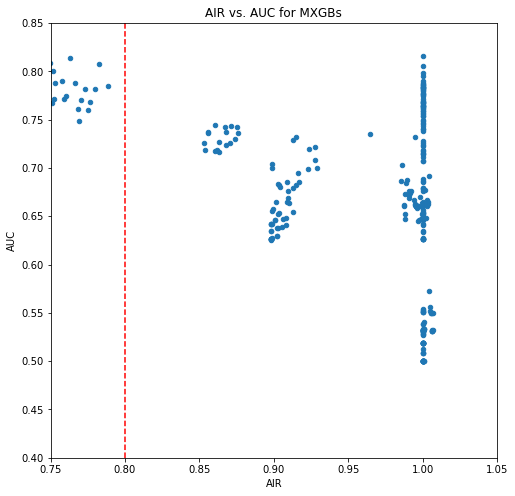

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
_ = mxgb_grid_frame.plot(kind='scatter', x='air', y='auc', title='AIR vs. AUC for MXGBs', ax=ax)
_ = ax.axvline(x=0.8, color='r', linestyle='--')
_ = ax.set_ylim([0.4, 0.85])
_ = ax.set_xlim([0.75, 1.05])
_ = ax.set_xlabel('AIR')
_ = ax.set_ylabel('AUC')

#### Retrain most accurate model above 0.8 AIR

In [ ]:
# extract new params dict from mxgb_grid_frame
rxgb_params = mxgb_grid_frame.loc[mxgb_grid_frame['air'] > 0.8].sort_values(by='auc', ascending=False).iloc[0, :].to_dict()

# extract features from dict then delete from dict
rxgb_x_names = rxgb_params['features']
del rxgb_params['features']

# extract monotonic constraints from dict
rxgb_mono_constraints = rxgb_params['monotone_constraints']
del rxgb_params['monotone_constraints']

# record and delete other extraneous information
print('Best AUC: %.4f above 0.8 AIR (%.4f).' % (rxgb_params['auc'], rxgb_params['air']))
rxgb_random_state = int(rxgb_params['seed'])
del rxgb_params['auc']
del rxgb_params['air']
del rxgb_params['booster']
del rxgb_params['eval_metric']
del rxgb_params['nthread']
del rxgb_params['objective']
del rxgb_params['seed']

gs_params = {}
for k, v in rxgb_params.items():
    gs_params[k] = [v]

# retrain
rxgb, rxgb_grid_frame = xgb_grid(train, valid, rxgb_x_names, y_name, gs_params=gs_params, n_models=1, ntree=1000, 
                                     early_stopping_rounds=100, mono_constraints=rxgb_mono_constraints, seed=rxgb_random_state)
print('Remediated EBM retrained with AUC: %.4f.' % rxgb.best_score)

Best AUC: 0.8153 above 0.8 AIR (1.0000).
Grid search run 1/1:
Training with parameters: {'booster': 'gbtree', 'eval_metric': 'auc', 'nthread': 4, 'objective': 'binary:logistic', 'seed': 12345, 'colsample_bytree': 0.7, 'colsample_bylevel': 0.7, 'eta': 0.005, 'max_depth': 7, 'reg_alpha': 0.0005, 'reg_lambda': 0.0005, 'subsample': 0.7, 'min_child_weight': 1, 'gamma': 0.3}
Grid search new best score discovered at iteration 1/1: 0.8153.
---------- ----------
Remediated EBM retrained with AUC: 0.8153.


#### Check that other groups are not adversely impacted by change 

In [ ]:
# create a frame with remediated XGB predictions
rdvalid = xgb.DMatrix(valid[rxgb_x_names], valid[y_name])
best_mxgb_phat2 = pd.DataFrame(rxgb.predict(rdvalid, iteration_range=(0, rxgb.best_ntree_limit)), columns=['phat']) 
best_mxgb_phat2 = pd.concat([valid.reset_index(drop=True), best_mxgb_phat2], axis=1)

# calculate new confusion matrices for each group
rem_cm_dict2 = {}
for name in demographic_group_names:
    rem_cm_dict2[name] = get_confusion_matrix(best_mxgb_phat2, y_name, 'phat', by=name, level=1, cutoff=0.17, verbose=False)

# calculate AIR for each group
print('Adverse impact ratio for Asian people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'asian', verbose=False))
print('Adverse impact ratio for Black people vs. White people: %.3f' % air(rem_cm_dict2, 'white', 'black', verbose=False))
print('Adverse impact ratio for Females vs. Males: %.3f' % air(rem_cm_dict2, 'male', 'female', verbose=False))

Adverse impact ratio for Asian people vs. White people: 1.000
Adverse impact ratio for Black people vs. White people: 1.000
Adverse impact ratio for Females vs. Males: 1.000


#### Print best model parameters for later use 

In [ ]:
rxgb_params

{'colsample_bytree': 0.7,
 'colsample_bylevel': 0.7,
 'eta': 0.005,
 'max_depth': 7,
 'reg_alpha': 0.0005,
 'reg_lambda': 0.0005,
 'subsample': 0.7,
 'min_child_weight': 1,
 'gamma': 0.3}

#### Print best model features for later use  

In [ ]:
rxgb_x_names

['debt_to_income_ratio_missing',
 'no_intro_rate_period_std',
 'term_360',
 'loan_amount_std',
 'debt_to_income_ratio_std',
 'conforming',
 'loan_to_value_ratio_std',
 'income_std',
 'intro_rate_period_std',
 'property_value_std']

#### End timer

In [ ]:
toc = time.time() - tic
print('All tasks completed in %.2f s.' % (toc))